# Siamese Network with Triplet Loss in Keras to differentiate between numbers in mnist dataset

In [1]:
%matplotlib notebook

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import random

from pca_plotter import PCAPlotter

print('TensorFlow version:', tf.__version__)

TensorFlow version: 2.3.0


### Importing the Data

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
print(x_train.shape)

11493376/11490434 [==============================] - 0s 0us/step
(60000, 28, 28)


In [3]:
x_train = np.reshape(x_train, (x_train.shape[0], 28**2))/255.
x_test = np.reshape(x_test, (x_test.shape[0], 28**2))/255.
print(x_train.shape)

(60000, 784)


### Plotting Examples

In [4]:
def plot_triplets(examples):
    plt.figure(figsize=(6, 2))
    for i in range(3):
        # 1 row 3 cols
        plt.subplot(1, 3, 1 + i)
        plt.imshow(np.reshape(examples[i], (28, 28)), cmap='binary')
        plt.xticks([])
        plt.yticks([])
    plt.show()

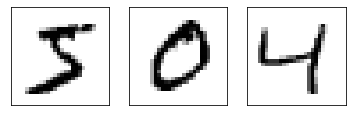

In [5]:
plot_triplets([x_train[0], x_train[1], x_train[2]])

### batch generator

In [6]:
def create_batch(batch_size=256):
    x_anchors = np.zeros((batch_size, 784))
    x_positives = np.zeros((batch_size, 784))
    x_negatives = np.zeros((batch_size, 784))
    
    for i in range(0, batch_size):
        # We need to find an anchor, a positive example and a negative example
        random_index = random.randint(0, x_train.shape[0] - 1)
        x_anchor = x_train[random_index]
        y = y_train[random_index]
        
        indices_for_pos = np.squeeze(np.where(y_train == y))
        indices_for_neg = np.squeeze(np.where(y_train != y))
        
        x_positive = x_train[indices_for_pos[random.randint(0, len(indices_for_pos) - 1)]]
        x_negative = x_train[indices_for_neg[random.randint(0, len(indices_for_neg) - 1)]]
        
        x_anchors[i] = x_anchor
        x_positives[i] = x_positive
        x_negatives[i] = x_negative
        
    return [x_anchors, x_positives, x_negatives]

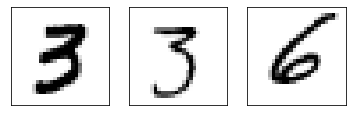

In [7]:
examples = create_batch(1)
plot_triplets(examples)

## Embedding Model

In [8]:
emb_size = 64

embedding_model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(784,)),
    tf.keras.layers.Dense(emb_size, activation='sigmoid')
])

embedding_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                50240     
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
Total params: 54,400
Trainable params: 54,400
Non-trainable params: 0
_________________________________________________________________


In [11]:
# example = np.expand_dims(x_train[0], axis=0)
# example_emb = embedding_model.predict(example)[0]

# print(len(example_emb))

## model for training embedding layer using triplet loss

In [12]:
input_anchor = tf.keras.layers.Input(shape=(784,))
input_positive = tf.keras.layers.Input(shape=(784,))
input_negative = tf.keras.layers.Input(shape=(784,))

embedding_anchor = embedding_model(input_anchor)
embedding_positive = embedding_model(input_positive)
embedding_negative = embedding_model(input_negative)

output = tf.keras.layers.concatenate([embedding_anchor, embedding_positive, embedding_negative], axis=1)

net = tf.keras.models.Model([input_anchor, input_positive, input_negative], output)
net.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 784)]        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 784)]        0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 784)]        0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 64)           54400       input_1[0][0]                    
                                                                 input_2[0][0]         

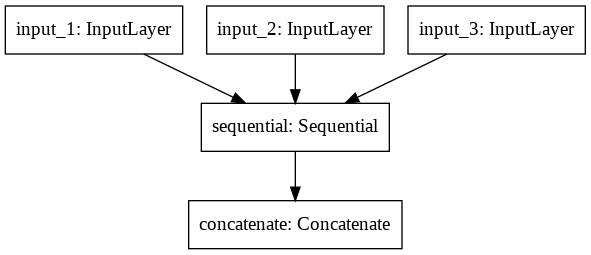

In [13]:
tf.keras.utils.plot_model(net)

#Implementing Triplet Loss

A loss function that tries to pull the Embeddings of Anchor and Positive Examples closer, and tries to push the Embeddings of Anchor and Negative Examples away from each other.

Taking mean square difference between Anchor and Positive examples in a batch of N images is:
$
\begin{equation}
d_p 
\end{equation}
$

Taking mean square difference between Anchor and Negative examples in a batch of N images is:
$
\begin{equation}
d_n 
\end{equation}
$

For each example, we want:
$
\begin{equation}
d_p \leq d_n
\end{equation}
$

Therefore,
$
\begin{equation}
d_p - d_n \leq 0
\end{equation}
$

This condition is quite easily satisfied during the training.

**We will make it non-trivial by adding a margin (alpha):**
$
\begin{equation}
d_p - d_n + \alpha \leq 0
\end{equation}
$

**thus making it necessary for dn to be more than dp by atleast alpha**

Given the condition above, the Triplet Loss L is defined as:
$
\begin{equation}
L = max(d_p - d_n + \alpha, 0)
\end{equation}
$

In [14]:
alpha = 0.2
# any custom loss function can have only (y_true, y_pred) as inputs
def triplet_loss(y_true, y_pred):
    anchor, positive, negative = y_pred[:,:emb_size], y_pred[:,emb_size:2*emb_size], y_pred[:,2*emb_size:]
    positive_dist = tf.reduce_mean(tf.square(anchor - positive), axis=1)
    negative_dist = tf.reduce_mean(tf.square(anchor - negative), axis=1)
    # we donot take square root to make sure the gradients do not die during training
    return tf.maximum(positive_dist - negative_dist + alpha, 0.)

## Data Generator

In [15]:
def data_generator(batch_size=256):
    while True:
        x = create_batch(batch_size)
        # we do not have any true labels, but to fit in the format we need dummy labels
        y = np.zeros((batch_size, 3*emb_size))
        yield x, y

## Model Training

Epoch 1/10
29/29 [==============================] - 26s 894ms/step - loss: 0.1620
Epoch 2/10
29/29 [==============================] - 26s 898ms/step - loss: 0.0782
Epoch 3/10
29/29 [==============================] - 26s 897ms/step - loss: 0.0563
Epoch 4/10
29/29 [==============================] - 26s 895ms/step - loss: 0.0495
Epoch 5/10
29/29 [==============================] - 26s 896ms/step - loss: 0.0443
Epoch 6/10
29/29 [==============================] - 26s 897ms/step - loss: 0.0414
Epoch 7/10
29/29 [==============================] - 26s 901ms/step - loss: 0.0381
Epoch 8/10
29/29 [==============================] - 26s 906ms/step - loss: 0.0350
Epoch 9/10
29/29 [==============================] - 26s 906ms/step - loss: 0.0332
Epoch 10/10
29/29 [==============================] - 26s 904ms/step - loss: 0.0316


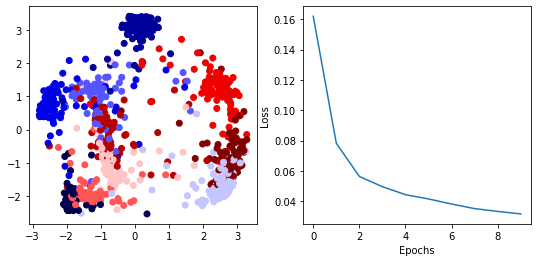

In [16]:
batch_size = 2048
epochs = 10
steps_per_epoch = int(x_train.shape[0]/batch_size)

net.compile(loss=triplet_loss, optimizer='adam')

_ = net.fit(
    data_generator(batch_size),
    steps_per_epoch=steps_per_epoch,
    epochs=epochs, verbose=1,
    callbacks=[
        PCAPlotter(
            plt, embedding_model,
            x_test[:1000], y_test[:1000]
        )]
)

In [242]:
# tryx = create_batch(batch_size=1)

In [243]:
# plot_triplets(tryx)

In [244]:
# a = embedding_model.predict(tryx[0])
# p = embedding_model.predict(tryx[1])
# n = embedding_model.predict(tryx[2])

In [245]:
# a.shape

In [246]:
# positive_dist = tf.reduce_mean(tf.square(a - p), axis=1)

In [247]:
# negative_dist = tf.reduce_mean(tf.square(a - n), axis=1)

In [248]:
# abs(float(negative_dist)-float(positive_dist))

# SAME OR NOT MODEL


In [142]:
input_a = tf.keras.layers.Input(shape=(784,))
input_b = tf.keras.layers.Input(shape=(784,))

emb_a = embedding_model(input_a)
emb_b = embedding_model(input_b)

dist = tf.keras.layers.Lambda(lambda x: abs(x[0] - x[1]))([emb_a, emb_b])
# dist = tf.keras.layers.Lambda(lambda x: tf.square(x[0] - x[1]))([emb_a, emb_b])

op = tf.keras.layers.Dense(1, activation='sigmoid')(dist)

similarity_model = tf.keras.models.Model([input_a, input_b], op)

In [143]:
similarity_model.layers[2].trainable = False

In [144]:
similarity_model.summary()

Model: "functional_12"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_28 (InputLayer)           [(None, 784)]        0                                            
__________________________________________________________________________________________________
input_29 (InputLayer)           [(None, 784)]        0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 64)           54400       input_28[0][0]                   
                                                                 input_29[0][0]                   
__________________________________________________________________________________________________
lambda_11 (Lambda)              (None, 64)           0           sequential[27][0]    

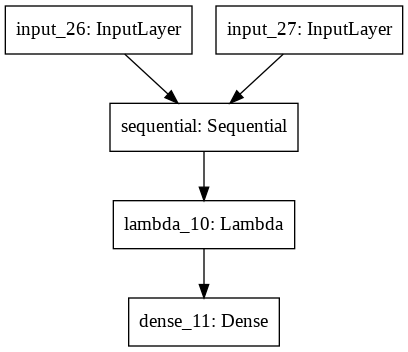

In [136]:
tf.keras.utils.plot_model(similarity_model)

In [145]:
def generator_for_similarity(batch_size = 256):
    while 1:
        a,p,n = create_batch(batch_size)
        A = np.zeros((batch_size, 28**2))
        B = np.zeros((batch_size, 28**2))
        Y = np.zeros((batch_size,))
        j = 0 
        for i in range(batch_size):
            if j<batch_size:
                A[j,:] = a[j,:]
                B[j,:] = p[j,:]
                Y[j,] = 1 
                j+=1 
            if j<batch_size:
                A[j,:] = a[j,:]
                B[j,:] = n[j,:]
                j+=1 
        yield [A,B], Y


In [146]:
similarity_model.compile(optimizer='adam', loss= 'binary_crossentropy', metrics = ['accuracy'])

In [147]:
similarity_model.fit(generator_for_similarity(),batch_size=256, steps_per_epoch=64, epochs = 5)

Epoch 1/5
64/64 [==============================] - 8s 120ms/step - loss: 0.6638 - accuracy: 0.5426
Epoch 2/5
64/64 [==============================] - 8s 120ms/step - loss: 0.5800 - accuracy: 0.6185
Epoch 3/5
64/64 [==============================] - 8s 121ms/step - loss: 0.5572 - accuracy: 0.6545
Epoch 4/5
64/64 [==============================] - 8s 120ms/step - loss: 0.5386 - accuracy: 0.6937
Epoch 5/5
64/64 [==============================] - 8s 120ms/step - loss: 0.5192 - accuracy: 0.7266


In [148]:
similarity_model.fit(generator_for_similarity(),batch_size=256, steps_per_epoch=64, epochs = 5)

Epoch 1/5
64/64 [==============================] - 8s 120ms/step - loss: 0.5053 - accuracy: 0.7534
Epoch 2/5
64/64 [==============================] - 8s 120ms/step - loss: 0.4942 - accuracy: 0.7833
Epoch 3/5
64/64 [==============================] - 8s 120ms/step - loss: 0.4854 - accuracy: 0.8007
Epoch 4/5
64/64 [==============================] - 8s 120ms/step - loss: 0.4723 - accuracy: 0.8204
Epoch 5/5
64/64 [==============================] - 8s 120ms/step - loss: 0.4645 - accuracy: 0.8266


In [156]:
def create_test_batch(batch_size=256):
    x_anchors = np.zeros((batch_size, 784))
    x_positives = np.zeros((batch_size, 784))
    x_negatives = np.zeros((batch_size, 784))
    
    for i in range(0, batch_size):
        # We need to find an anchor, a positive example and a negative example
        random_index = random.randint(0, x_test.shape[0] - 1)
        x_anchor = x_test[random_index]
        y = y_test[random_index]
        
        indices_for_pos = np.squeeze(np.where(y_test == y))
        indices_for_neg = np.squeeze(np.where(y_test != y))
        
        x_positive = x_test[indices_for_pos[random.randint(0, len(indices_for_pos) - 1)]]
        x_negative = x_test[indices_for_neg[random.randint(0, len(indices_for_neg) - 1)]]
        
        x_anchors[i] = x_anchor
        x_positives[i] = x_positive
        x_negatives[i] = x_negative
        
    return [x_anchors, x_positives, x_negatives]

In [255]:
def try1(i=random.randint(0,1)):
    batch_size = 1
    # ri = random.randint(0,1)
    a,p,n = create_test_batch(batch_size)
    A = np.zeros((batch_size, 28**2))
    B = np.zeros((batch_size, 28**2))
    Y = np.zeros((batch_size,))
    j=0
    if i:
        A[j,:] = a[j,:]
        B[j,:] = p[j,:]
        Y[j,] = 1 
        j+=1 
    else:
        A[j,:] = a[j,:]
        B[j,:] = n[j,:]
    a,b,tl = A,B,Y
    yh=similarity_model.predict([a,b])[0][0]
    print("originally", 'same' if tl[0]==1.0 else 'different') 
    print("predicted", 'same' if yh>=0.5 else 'different'  ,f"{yh*100:.2f}%")
    plt.subplot(1,2,1)
    plt.imshow(a[0].reshape((28,28)), cmap='gray')
    plt.subplot(1,2,2)
    plt.imshow(b[0].reshape((28,28)), cmap='gray')
    

## Model evaluation

In [249]:
def generator_for_similarity_test(batch_size):
    while 1:
        a,p,n = create_test_batch(batch_size)
        A = np.zeros((batch_size, 28**2))
        B = np.zeros((batch_size, 28**2))
        Y = np.zeros((batch_size,))
        j = 0 
        for i in range(batch_size):
            if j<batch_size:
                A[j,:] = a[j,:]
                B[j,:] = p[j,:]
                Y[j,] = 1 
                j+=1 
            if j<batch_size:
                A[j,:] = a[j,:]
                B[j,:] = n[j,:]
                j+=1 
        yield [A,B], Y

In [254]:
similarity_model.evaluate(generator_for_similarity_test(batch_size=2048),steps=10)

10/10 [==============================] - 2s 190ms/step - loss: 0.4564 - accuracy: 0.8391


[0.45642098784446716, 0.839111328125]

originally same
predicted same 58.78%


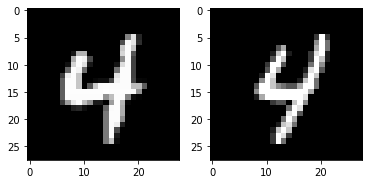

In [260]:
try1(1)

originally different
predicted different 8.40%


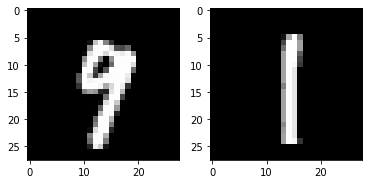

In [261]:
try1(0)

originally same
predicted different 39.73%


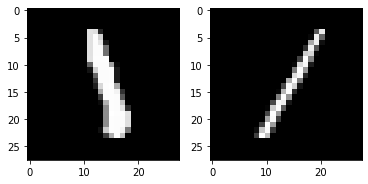

In [262]:
try1(1)

originally different
predicted different 14.26%


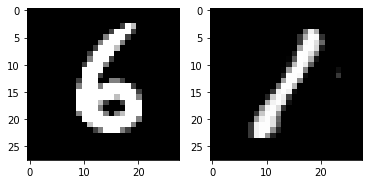

In [263]:
try1(0)